In [1]:
%load_ext autoreload

%autoreload 2

from glob import glob
from os.path import join
import os
import pickle

import scipy.linalg
import matplotlib
matplotlib.rcParams["figure.dpi"] = 144
matplotlib.rcParams["savefig.dpi"] = 144
import matplotlib.pyplot as plt
import numpy as np

from astropy.table import Table, Column
import astropy.units as u

import emcee

import kepler
import threebody

import minuit_wrap
%matplotlib inline

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
#logger.setLevel(logging.INFO)
logging.debug("test")

DEBUG:root:test


In [2]:
d = pickle.load(open("fitter_params.pickle"))
F = threebody.Fitter(**d)
params = d

DEBUG:threebody:Fitting DM
DEBUG:threebody:base telescope AO_1400 from list of ['AO_1400', 'AO_430', 'GBT_1400', 'WSRT_1400', 'WSRT_350']


In [3]:
F.residuals(F.best_parameters)

DEBUG:threebody:Started residuals for {'f0': 365.95336311128915, 'shapiro': True, 'j_NCY1400': 0.000675, 'asini_i': 1.2175265019387542758, 'eps2_i': -9.1300073961811384699e-05, 'delta_lan': -9.8698650879648641589e-06, 'eps2_o': -0.003462177678515299745, 'q_i': 0.13730684938043949346, 'asini_o': 74.672702906402272566, 'j_GBT350': 1.8517017863581812e-05, 'dgamma': 0.00020638502444498746259, 'tasc_i': 0.40771691870264608189, 'ppn_mode': 'heavysimple', 'd_RAJ': -3.4254785902426147e-09, 'acosi_i': 1.4922378021036498232, 'acosi_o': 91.474385642988143237, 'tasc_o': 313.93578089310207763, 'eps1_o': 0.035186238583013847816, 'eps1_i': 0.00068708310951100119386, 'tol': 1e-16, 'd_PMRA': 9.885280864586482e-11, 'j_WSRT350': -3.659850586544055e-05, 'd_PMDEC': -1.9580532733266362e-10, 'j_GBT820': 6.785312385988059e-05, 'use_quad': False, 'd_PX': -0.5531255775641357, 'j_AO327': 6.509749509896134e-05, 'd_DECJ': -1.070731501745044e-09, 'delta': -1.0316357225747149967e-09, 'j_AO1440': 4.8927007422127645e-

array([ 4.5309745e+09,  4.2102823e+09,  4.1824314e+09, ..., -5.6528015e+10,
       -5.6528015e+10, -5.6528015e+10], dtype=float128)

In [4]:
vals, names = F.compute_linear_parts(F.best_parameters)
lp = dict(zip(names, vals))
der = dict(zip(F.jnames, F.jmatrix.T))

DEBUG:threebody:Computing linear parts
DEBUG:threebody:Computing linear matrix
DEBUG:threebody:Started compute_orbit for {'f0': 365.95336311128915, 'shapiro': True, 'j_NCY1400': 0.000675, 'asini_i': 1.2175265019387542758, 'eps2_i': -9.1300073961811384699e-05, 'delta_lan': -9.8698650879648641589e-06, 'eps2_o': -0.003462177678515299745, 'q_i': 0.13730684938043949346, 'asini_o': 74.672702906402272566, 'j_GBT350': 1.8517017863581812e-05, 'dgamma': 0.00020638502444498746259, 'tasc_i': 0.40771691870264608189, 'ppn_mode': 'heavysimple', 'd_RAJ': -3.4254785902426147e-09, 'acosi_i': 1.4922378021036498232, 'acosi_o': 91.474385642988143237, 'tasc_o': 313.93578089310207763, 'eps1_o': 0.035186238583013847816, 'eps1_i': 0.00068708310951100119386, 'tol': 1e-16, 'd_PMRA': 9.885280864586482e-11, 'j_WSRT350': -3.659850586544055e-05, 'd_PMDEC': -1.9580532733266362e-10, 'j_GBT820': 6.785312385988059e-05, 'use_quad': False, 'd_PX': -0.5531255775641357, 'j_AO327': 6.509749509896134e-05, 'd_DECJ': -1.0707315

In [5]:
d = dict()
d.update(der)
res = F.residuals(F.best_parameters)
d["resid_phase"] = res
d["resid_s"] = res/F.reference_f0
d["uncert_phase"] = F.uncerts
toa_info = F.annotated_toas(d)

DEBUG:threebody:Started residuals for {'f0': 365.95336311128915, 'shapiro': True, 'j_NCY1400': 0.000675, 'asini_i': 1.2175265019387542758, 'eps2_i': -9.1300073961811384699e-05, 'delta_lan': -9.8698650879648641589e-06, 'eps2_o': -0.003462177678515299745, 'q_i': 0.13730684938043949346, 'asini_o': 74.672702906402272566, 'j_GBT350': 1.8517017863581812e-05, 'dgamma': 0.00020638502444498746259, 'tasc_i': 0.40771691870264608189, 'ppn_mode': 'heavysimple', 'd_RAJ': -3.4254785902426147e-09, 'acosi_i': 1.4922378021036498232, 'acosi_o': 91.474385642988143237, 'tasc_o': 313.93578089310207763, 'eps1_o': 0.035186238583013847816, 'eps1_i': 0.00068708310951100119386, 'tol': 1e-16, 'd_PMRA': 9.885280864586482e-11, 'j_WSRT350': -3.659850586544055e-05, 'd_PMDEC': -1.9580532733266362e-10, 'j_GBT820': 6.785312385988059e-05, 'use_quad': False, 'd_PX': -0.5531255775641357, 'j_AO327': 6.509749509896134e-05, 'd_DECJ': -1.070731501745044e-09, 'delta': -1.0316357225747149967e-09, 'j_AO1440': 4.8927007422127645e-

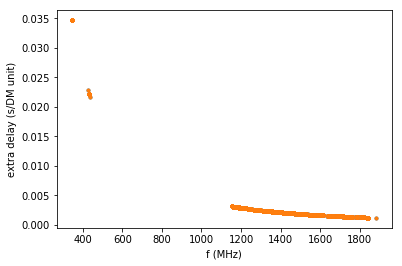

In [6]:
freqs = np.array([t["freq"] for t in toa_info])
d_DMs = np.array([float(t["flags"]["d_DM"]) for t in toa_info])
fmla = 4.15e6/freqs**2 * 1e-3

plt.plot(freqs, fmla,".")
plt.plot(freqs, d_DMs,".")
plt.xlabel("f (MHz)")
plt.ylabel("extra delay (s/DM unit)")

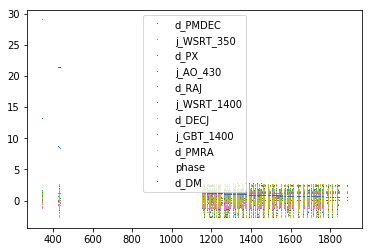

In [7]:
for k in der:
    d = der[k]
    d /= np.sqrt(np.mean(d**2))
    plt.plot(freqs, d, ",", label=k)
plt.legend(loc="upper center")

We have the derivative of delay, in seconds, with respect to DM, stored in `d_DM`. We solved for the constant `c` that made `c*d_DM` line up with our residuals, measured in phase. So `(c/f0)*d_DM` should line up with our residuals in seconds, and so the actual change in DM called for should be `c/f0` DM units. 

In [8]:
# The fit was to phase not seconds; check correction factor and sign
dm_correction = lp["d_DM"]/F.reference_f0 
print dm_correction, "pc/cm^3"


-0.00293294184253 pc/cm^3


(21.313, 21.315932941842529886)


INFO:threebody:tempo2 output appears to be old, deleting to trigger recomputation
DEBUG:threebody:Fitting DM
DEBUG:threebody:base telescope AO_1400 from list of ['AO_1400', 'AO_430', 'GBT_1400', 'WSRT_1400', 'WSRT_350']
DEBUG:threebody:Started residuals for {'f0': 365.95336311128915, 'shapiro': True, 'j_NCY1400': 0.000675, 'asini_i': 1.2175265019387542758, 'eps2_i': -9.1300073961811384699e-05, 'delta_lan': -9.8698650879648641589e-06, 'eps2_o': -0.003462177678515299745, 'q_i': 0.13730684938043949346, 'asini_o': 74.672702906402272566, 'j_GBT350': 1.8517017863581812e-05, 'dgamma': 0.00020638502444498746259, 'tasc_i': 0.40771691870264608189, 'ppn_mode': 'heavysimple', 'd_RAJ': -3.4254785902426147e-09, 'acosi_i': 1.4922378021036498232, 'acosi_o': 91.474385642988143237, 'tasc_o': 313.93578089310207763, 'eps1_o': 0.035186238583013847816, 'eps1_i': 0.00068708310951100119386, 'tol': 1e-16, 'd_PMRA': 9.885280864586482e-11, 'j_WSRT350': -3.659850586544055e-05, 'd_PMDEC': -1.9580532733266362e-10, 

DEBUG:threebody:Residual chi-squared: 151301.177117
DEBUG:threebody:Residual chi-squared: 151134.314132
DEBUG:threebody:Residual chi-squared: 151134.313745
DEBUG:threebody:Done linear least-squares
DEBUG:threebody:Computing linear parts
DEBUG:threebody:Computing linear matrix
DEBUG:threebody:Started compute_orbit for {'f0': 365.95336311128915, 'shapiro': True, 'j_NCY1400': 0.000675, 'asini_i': 1.2175265019387542758, 'eps2_i': -9.1300073961811384699e-05, 'delta_lan': -9.8698650879648641589e-06, 'eps2_o': -0.003462177678515299745, 'q_i': 0.13730684938043949346, 'asini_o': 74.672702906402272566, 'j_GBT350': 1.8517017863581812e-05, 'dgamma': 0.00020638502444498746259, 'tasc_i': 0.40771691870264608189, 'ppn_mode': 'heavysimple', 'd_RAJ': -3.4254785902426147e-09, 'acosi_i': 1.4922378021036498232, 'acosi_o': 91.474385642988143237, 'tasc_o': 313.93578089310207763, 'eps1_o': 0.035186238583013847816, 'eps1_i': 0.00068708310951100119386, 'tol': 1e-16, 'd_PMRA': 9.885280864586482e-11, 'j_WSRT350':

(2.2020636604358574321e+32, 2.2020636604358574321e+32)
-0.00293294184253 7.90984426489e-08
-0.00293294184253 0.00293302094097


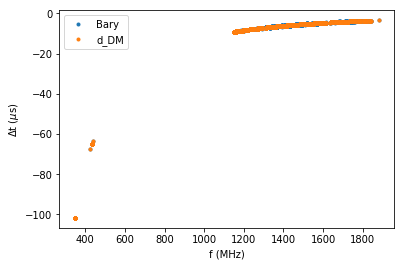

In [9]:
par = params["parfile"]
par2 = par[:par.rindex(".")]+"_dmcorr.par"
with open(par2, "wt") as f:
    for l in open(par, "rt").readlines():
        if l.startswith("DM"):
            dm = float(l.split()[1])
            dm2 = dm-dm_correction
            print(dm, dm2)
            f.write("DM %f\n" % dm2)
        else:
            f.write(l)

params2 = params.copy()
params2["parfile"] = par2
F2 = threebody.Fitter(**params2)
print(F.goodness_of_fit(F.best_parameters), 
      F2.goodness_of_fit(F.best_parameters))
vals, names = F2.compute_linear_parts(F.best_parameters)
lp2 = dict(zip(names, vals))
print lp["d_DM"]/F.reference_f0, lp2["d_DM"]/F.reference_f0
print dm_correction, (lp2["d_DM"]-lp["d_DM"])/F.reference_f0

plt.plot(freqs, 1e6*(F2.mjds-F.mjds)*86400, ".", label="Bary")
plt.plot(freqs, 1e6*d_DMs*dm_correction, ".", label="d_DM")
plt.xlabel("f (MHz)")
plt.ylabel(r"$\Delta$t ($\mu$s)")
plt.legend()



DEBUG:threebody:Started compute_orbit for {'f0': 365.95336311128915, 'shapiro': True, 'j_NCY1400': 0.000675, 'asini_i': 1.2175265019387542758, 'eps2_i': -9.1300073961811384699e-05, 'delta_lan': -9.8698650879648641589e-06, 'eps2_o': -0.003462177678515299745, 'q_i': 0.13730684938043949346, 'asini_o': 74.672702906402272566, 'j_GBT350': 1.8517017863581812e-05, 'dgamma': 0.00020638502444498746259, 'tasc_i': 0.40771691870264608189, 'ppn_mode': 'heavysimple', 'd_RAJ': -3.4254785902426147e-09, 'acosi_i': 1.4922378021036498232, 'acosi_o': 91.474385642988143237, 'tasc_o': 313.93578089310207763, 'eps1_o': 0.035186238583013847816, 'eps1_i': 0.00068708310951100119386, 'tol': 1e-16, 'd_PMRA': 9.885280864586482e-11, 'j_WSRT350': -3.659850586544055e-05, 'd_PMDEC': -1.9580532733266362e-10, 'j_GBT820': 6.785312385988059e-05, 'use_quad': False, 'd_PX': -0.5531255775641357, 'j_AO327': 6.509749509896134e-05, 'd_DECJ': -1.070731501745044e-09, 'delta': -1.0316357225747149967e-09, 'j_AO1440': 4.89270074221276

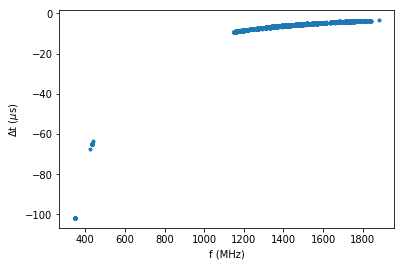

In [10]:
orbit = F.compute_orbit(F.best_parameters)
orbit2 = F2.compute_orbit(F.best_parameters)

t_psr = orbit['t_psr']
t_psr2 = orbit2['t_psr']

plt.plot(freqs, 1e6*(t_psr2-t_psr)*86400, ".")
plt.xlabel("f (MHz)")
plt.ylabel(r"$\Delta$t ($\mu$s)")
